In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [41]:
def P_func(S):
    return 2/np.pi * np.arctan(5*S)

def Y_func_treated(S, std=0.05):
    return -0.5 * S + 0.75 + np.random.normal(loc=0.0, scale=std, size=len(S))
def Y_func_untreated(S, std=0.05):
    return -0.8 * S + 0.9 + np.random.normal(loc=0.0, scale=std, size=len(S))

def Y_func(T, S, std=0.05):
    Y = T.copy().astype(float)
    Y[T==1] = Y_func_treated(  S[T==1], std=std)
    Y[T==0] = Y_func_untreated(S[T==0], std=std)
    
    return Y

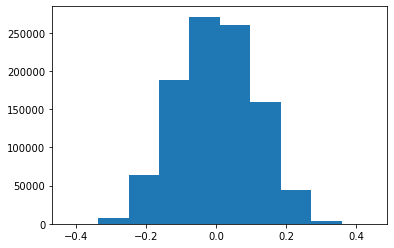

In [78]:
np.random.seed(90)
N = 1000000
S = np.random.uniform(size=N)
T = (P_func(S) > np.random.uniform(size=N)).astype(int)
Y = Y_func(T,S)

Y_treated   = Y[T == 1]
Y_untreated = Y[T == 0]

naive_ate = np.mean(Y_treated)- np.mean(Y_untreated)
true_ate  = np.mean(Y_func_treated(S)) - np.mean(Y_func_untreated(S))

plt.hist(Y_func_treated(S) - Y_func_untreated(S))
plt.show()

Text(0, 0.5, 'T')

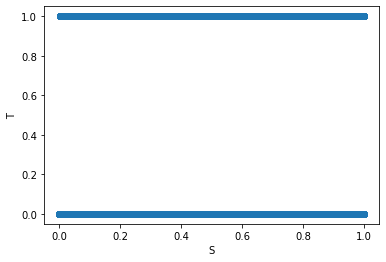

In [9]:
plt.scatter(S, T)
plt.xlabel("S")
plt.ylabel("T")

Text(0, 0.5, 'Y')

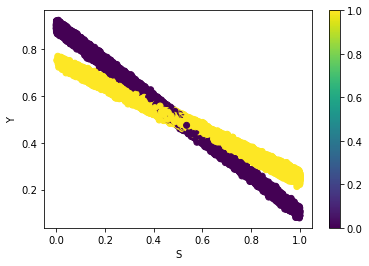

In [59]:
plt.scatter(S, Y, c=T)
plt.colorbar()
plt.xlabel("S")
plt.ylabel("Y")

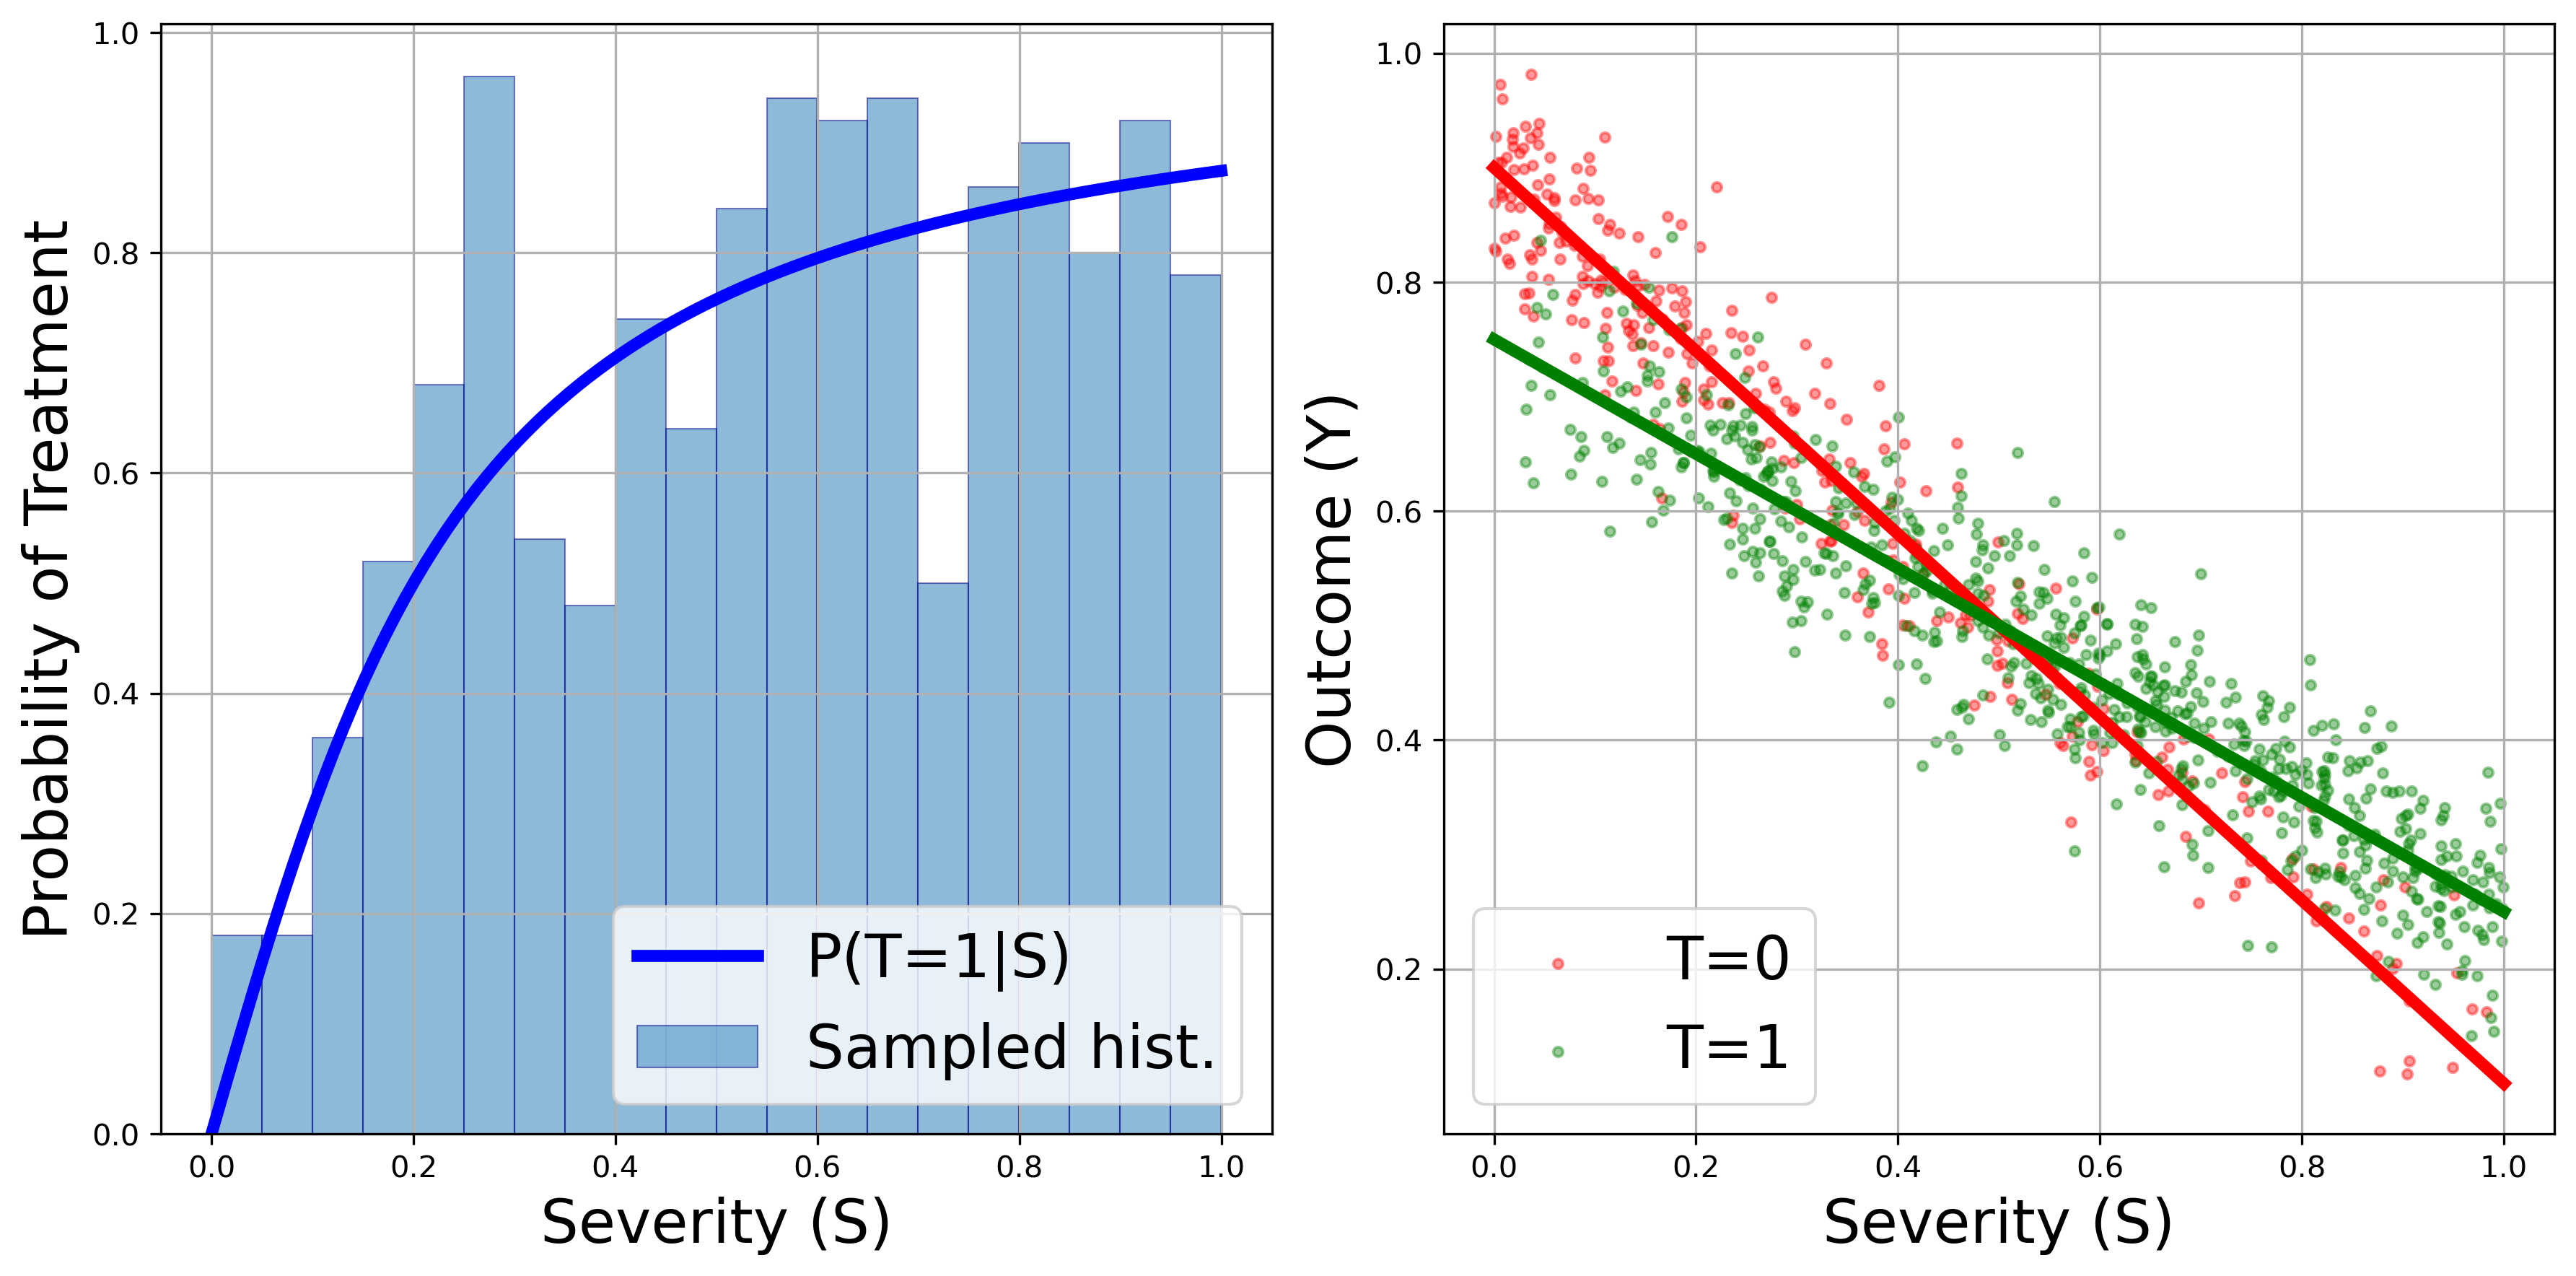

In [74]:
# Create a finer S for smoother plots
S_fine = np.linspace(0, 1, 100)
P_fine = P_func(S_fine)

# Plotting
plt.figure(figsize=(12, 6), dpi=300)

# Plot the propensity score
plt.subplot(1, 2, 1)
plt.plot(S_fine, P_fine, label='P(T=1|S)', color='blue', lw=4)
res = plt.hist(S, weights=T/50, bins=20, density=False,
               alpha=0.5, edgecolor='darkblue', linewidth=0.5, label="Sampled hist.")
# plt.fill_between(S_fine, 0, P_fine, color='blue', alpha=0.1)
# plt.title('Propensity Score vs Severity', fontsize=20)
plt.xlabel('Severity (S)', fontsize=20)
plt.ylabel('Probability of Treatment', fontsize=20)
plt.grid()
plt.legend(fontsize=20, loc="lower right")

# Plot the outcomes
plt.subplot(1, 2, 2)
plt.scatter(S[T==0], Y[T==0], color='red',   alpha=0.4, label='T=0', s=10)
plt.scatter(S[T==1], Y[T==1], color='green', alpha=0.4, label='T=1', s=10)
Z = np.linspace(0,1,100)
plt.plot(Z, Y_func_untreated(Z, 0), color="red", linewidth=4)
plt.plot(Z, Y_func_treated(Z, 0),   color="green", linewidth=4)
# plt.title('Outcomes vs Severity', fontsize=20)
plt.xlabel('Severity (S)', fontsize=20)
plt.ylabel('Outcome (Y)', fontsize=20)
plt.grid()
plt.legend(fontsize=20, loc="lower left")

plt.tight_layout()

plt.savefig("treatment-probability-function.pdf", bbox_inches="tight")

plt.show()

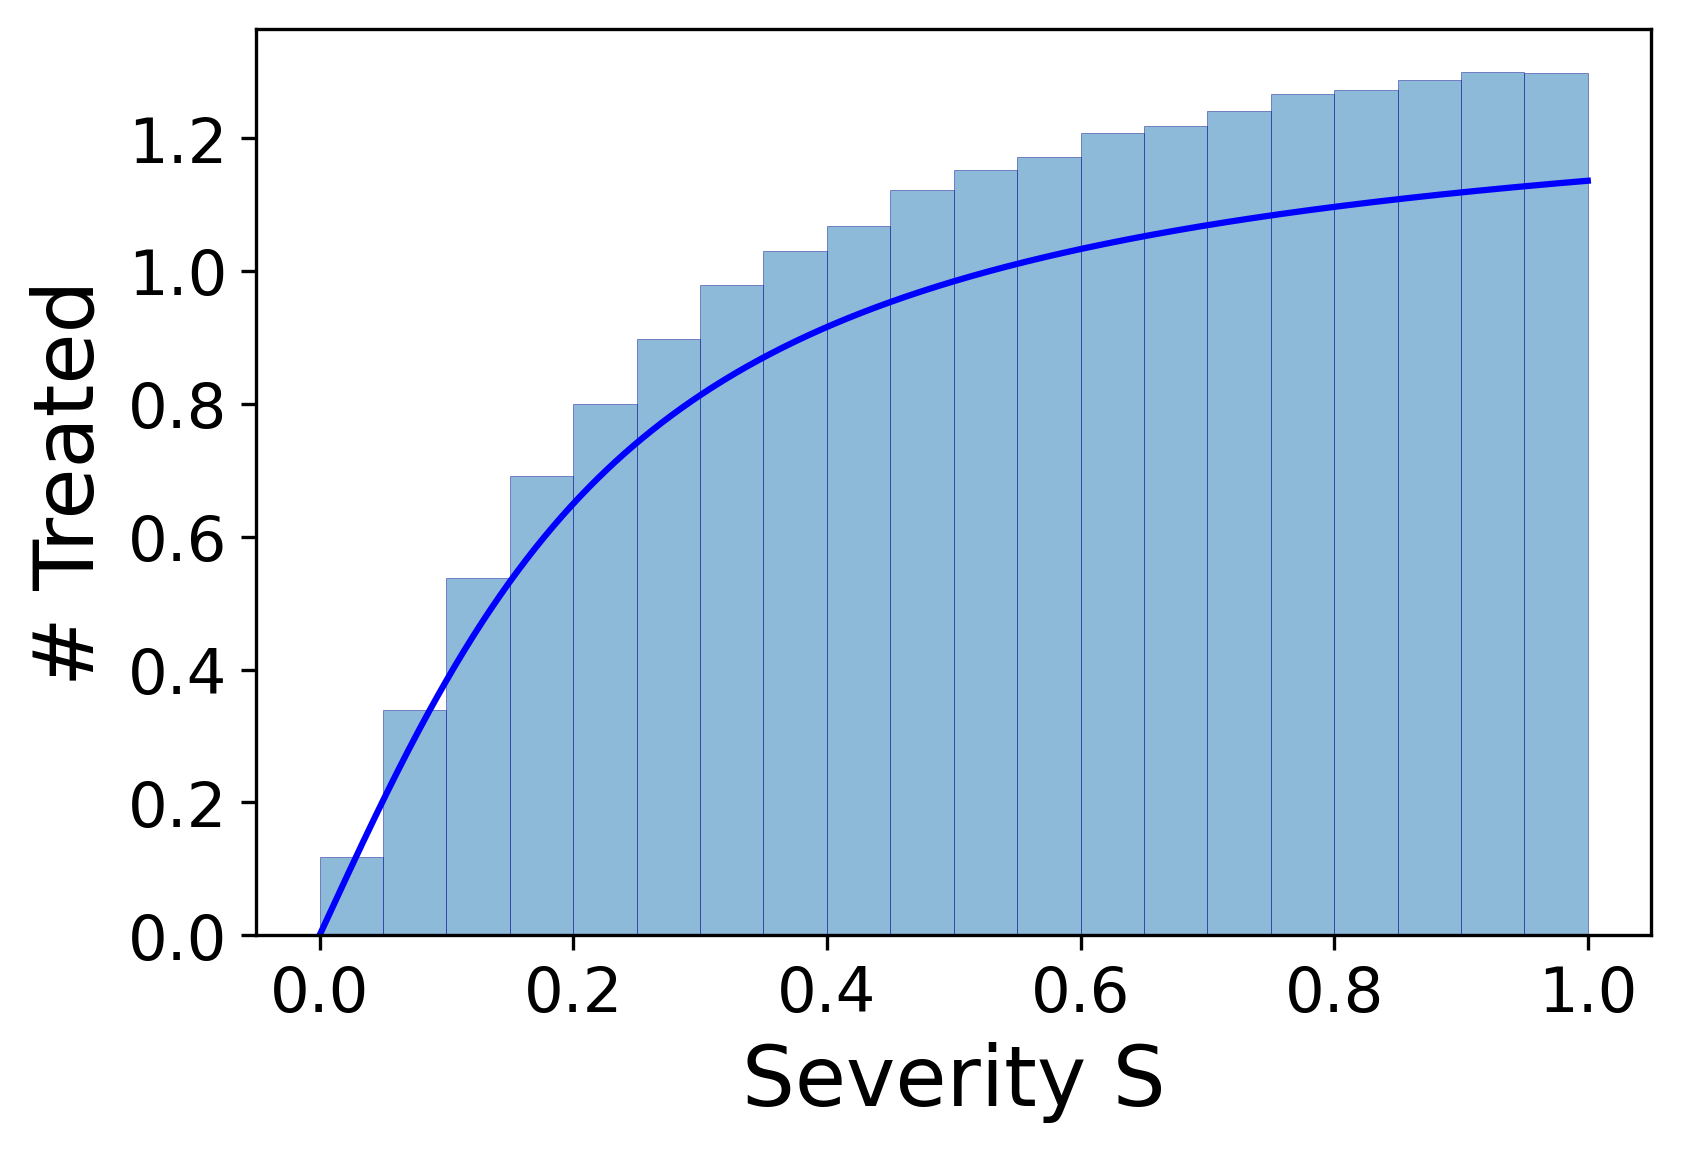

In [10]:
plt.figure(dpi=300)
res = plt.hist(S, weights=T, bins=20, density=True,
               alpha=0.5, edgecolor='darkblue', linewidth=0.2, label="Sampled Probability Function")
x = np.linspace(0,1,1000)
plt.plot(x, P_func(x) * np.max(res[0]), c="blue", label="Treatment Probability Function") # * np.max(res[0])
plt.xlabel("Severity S", size=20)
plt.ylabel("# Treated", size=20)
plt.tick_params(axis='both', labelsize=15)
# plt.legend()
plt.savefig("treatment-probability-function.svg", bbox_inches="tight")
plt.show()

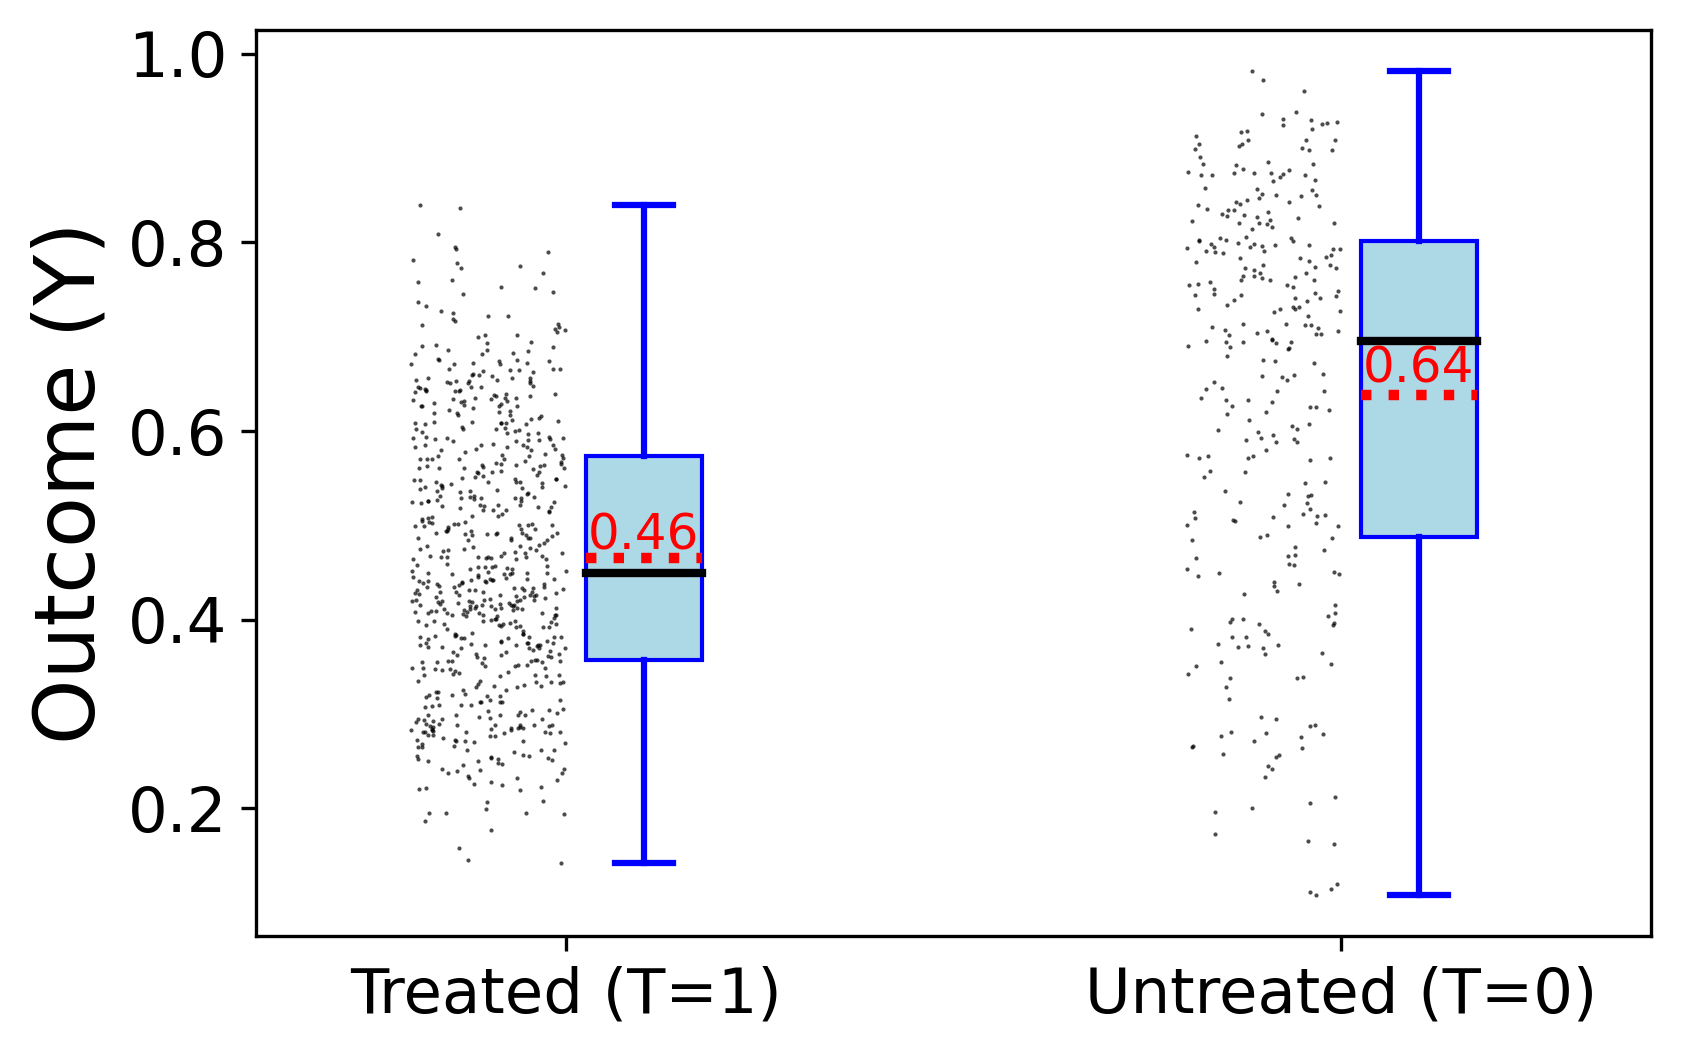

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Y = np.random.rand(100)  # Outcomes in the range [0, 1]
# T = np.random.randint(0, 2, size=100)  # Binary treatment (0 or 1)


fig, ax = plt.subplots(dpi=300)

ax.boxplot([Y[T == 1], Y[T == 0]], positions=[0.2, 1.2], patch_artist=True, showmeans=True,meanline=True,
           boxprops=dict(facecolor='lightblue', color='blue'),
           medianprops=dict(color='black', linewidth=2),
           whiskerprops=dict(color='blue', linewidth=1.5),
           meanprops=dict(linestyle=':', linewidth=2.5, color='red'),
           capprops=dict(color='blue', linewidth=1.5),
           flierprops=dict(marker='o', color='blue', alpha=0.5))

sns.stripplot(data=[Y_treated, Y_untreated], jitter=True, ax=ax, size=1, color='black', alpha=0.7, dodge=True)

# plt.axhline(np.mean(Y_treated), xmin=0.1, xmax=0.4)

# Calculate means
mean_treated = np.mean(Y_treated)
mean_untreated = np.mean(Y_untreated)

# Add text for the means below each box
ax.text(0.2, mean_treated + (0.02 * mean_treated), f'{mean_treated:.2f}', ha='center', fontsize=12, color="red")
ax.text(1.2, mean_untreated + (0.02 * mean_untreated), f'{mean_untreated:.2f}', ha='center', fontsize=12, color="red")

ax.set_xticks([0.1, 1.1])
ax.set_xlim([-0.3,1.5])
ax.set_xticklabels(['Treated (T=1)', 'Untreated (T=0)'], size=20)
ax.set_ylabel('Outcome (Y)', size=20)
plt.tick_params(axis='both', labelsize=15)

# ax.set_title('Box Plot of Treated and Untreated Outcomes')
plt.savefig("box-plot.pdf", bbox_inches="tight")
plt.show()


# IPW ATE Estimator

In [20]:
def compute_IPW_ATE(S, T, Y):
    return (np.average(Y[T == 1], weights=(1 /      P_func(S[T == 1])))   - 
            np.average(Y[T == 0], weights=(1 / (1 - P_func(S[T == 0])))))

## Using true P(T|S)

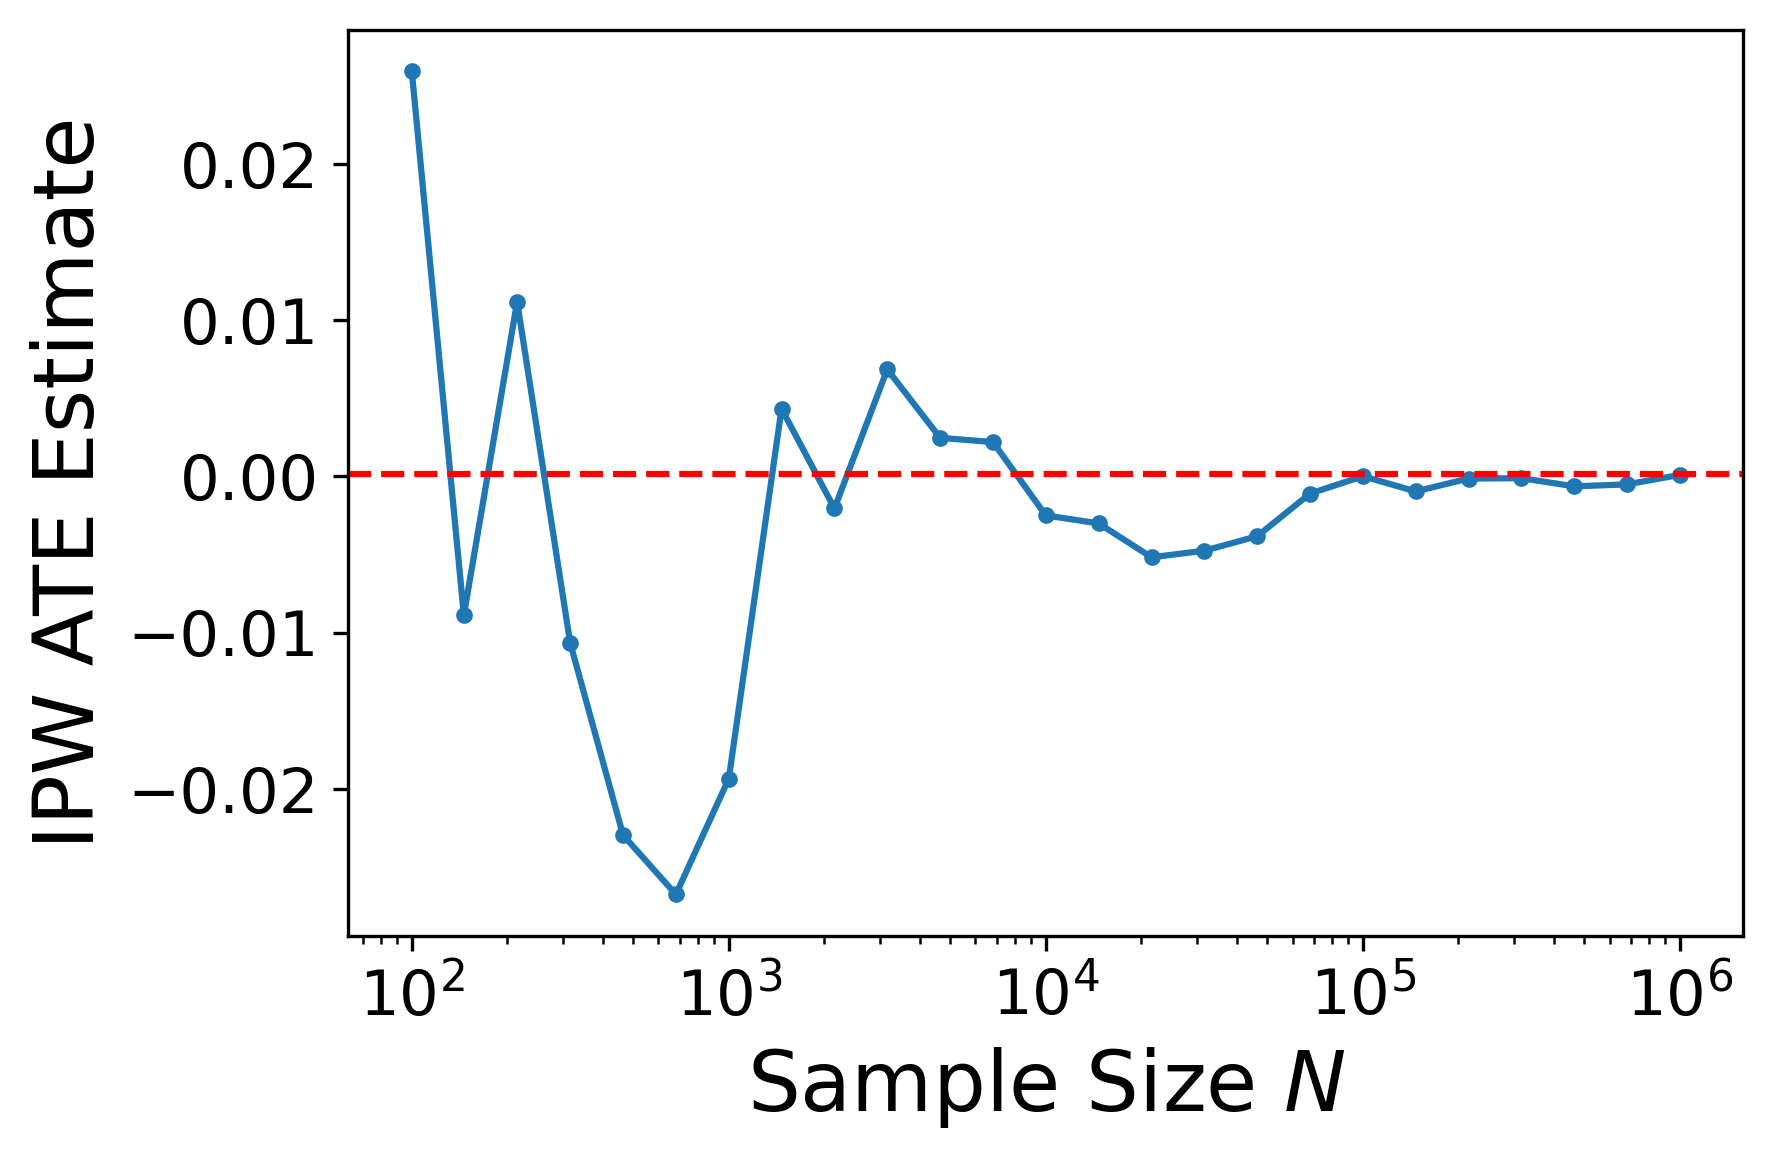

In [80]:
sample_sizes = np.logspace(2, 6, 25).astype(int)
ate_estimates = []
true_ate = np.mean(Y_func(np.ones_like(S), S) - Y_func(np.zeros_like(S), S))

for n in sample_sizes:
    S_sample = S[:n]
    T_sample = T[:n]
    Y_sample = Y[:n]
    P_sample = P_func(S_sample)
    weights_treated = 1 / P_sample[T_sample == 1]
    weights_untreated = 1 / (1 - P_sample[T_sample == 0])
    ate_estimate = (np.average(Y_sample[T_sample == 1], weights=weights_treated) -
                    np.average(Y_sample[T_sample == 0], weights=weights_untreated))
    ate_estimates.append(compute_IPW_ATE(S[:n], T[:n], Y[:n]))

plt.figure(dpi=300)
plt.plot(sample_sizes, ate_estimates, label="Estimated ATE (IPW)", marker='.')
plt.axhline(y=true_ate, color='red', linestyle='--', label="True ATE")
plt.xscale('log')
plt.xlabel(r"Sample Size $N$", size=20)
plt.ylabel("IPW ATE Estimate", size=20)
plt.tick_params(axis='both', labelsize=15)
# plt.title("IPW ATE Convergence with Sample Size")
plt.savefig("ipw-ate.pdf", bbox_inches="tight")
plt.show()

## Using linear regression to determine P(T|S)

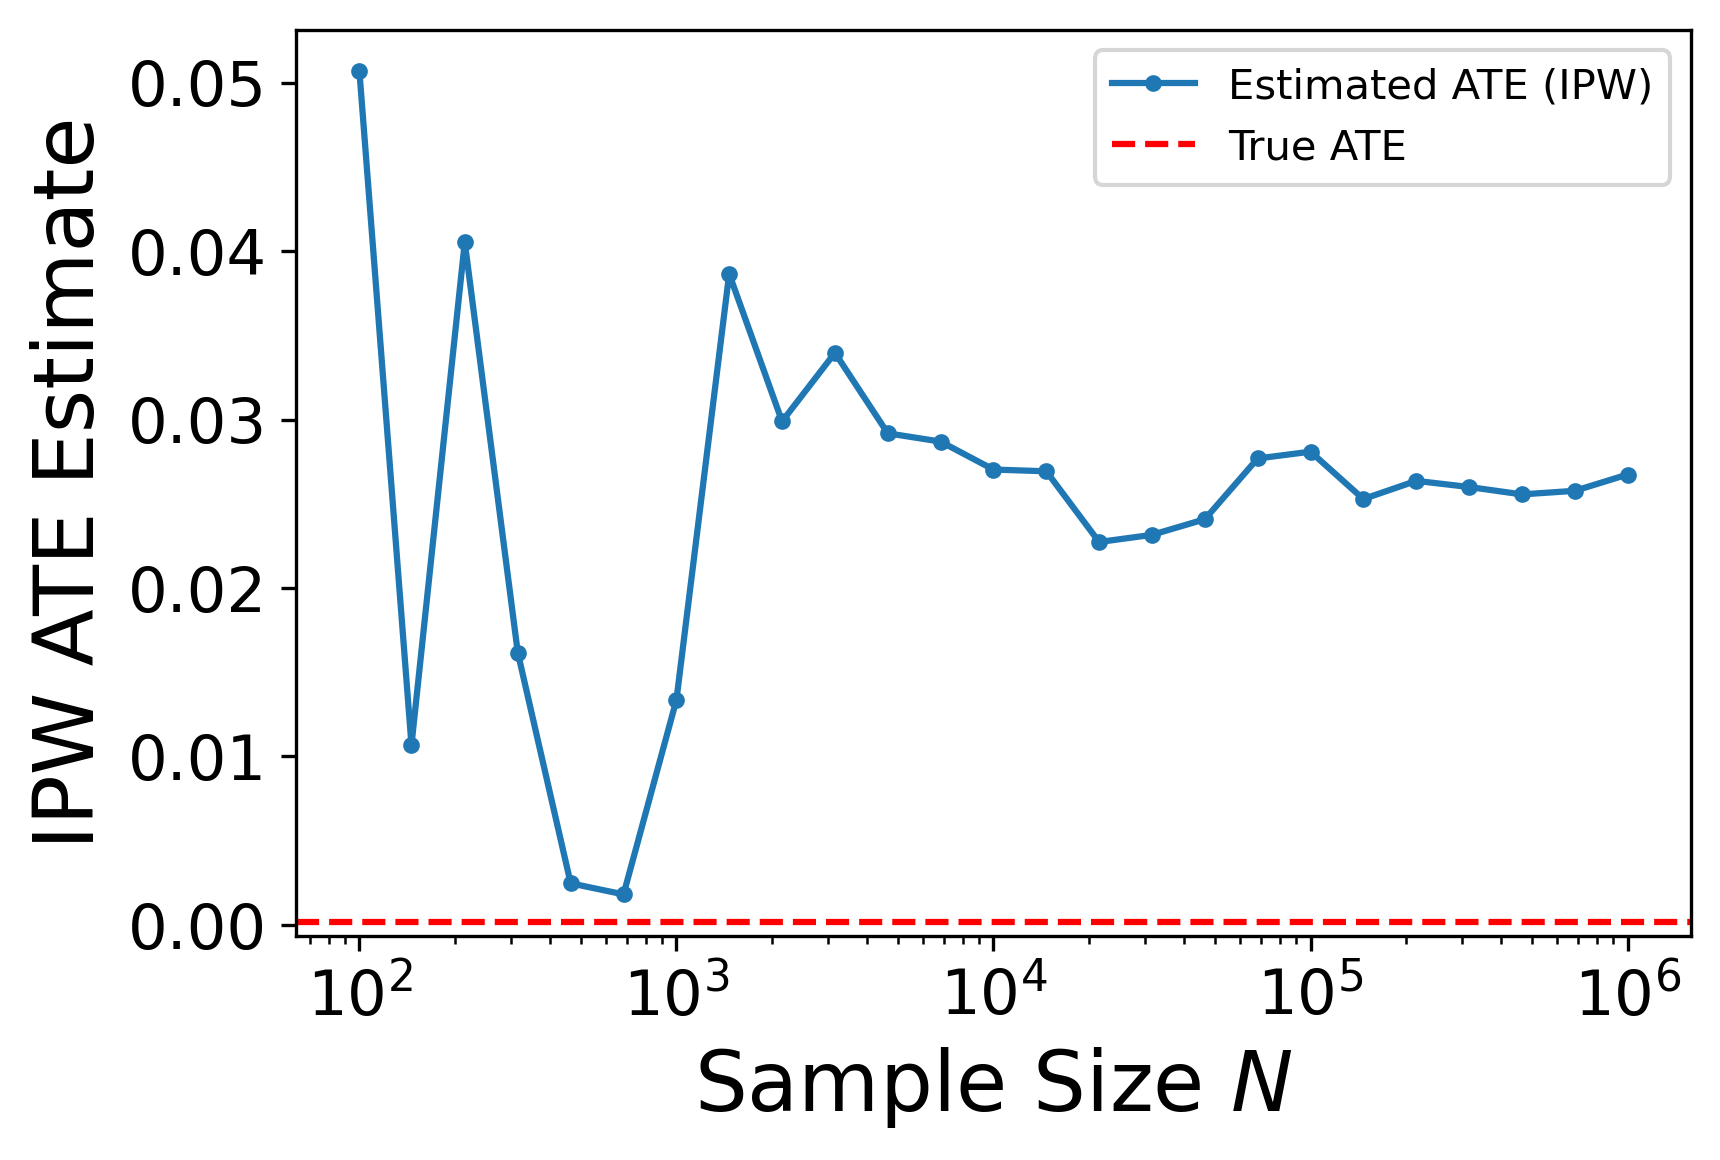

In [27]:
from sklearn.linear_model import LogisticRegression

# ATE Convergence with Sample Size
sample_sizes = np.logspace(2, 6, 25).astype(int)
ate_estimates = []
true_ate = np.mean(Y_func(np.ones_like(S), S) - Y_func(np.zeros_like(S), S))

# Fit logistic regression on the full dataset to predict P(T=1|S)
log_reg = LogisticRegression()
log_reg.fit(S.reshape(-1, 1), T)  # S as input, T as the binary treatment (0 or 1)

for n in sample_sizes:
    S_sample = S[:n]
    T_sample = T[:n]
    Y_sample = Y[:n]
    
    # Predict the propensity scores using logistic regression
    P_sample = log_reg.predict_proba(S_sample.reshape(-1, 1))[:, 1]  # Probabilities of T=1
    
    # Inverse Probability Weighting for treated and untreated groups
    weights_treated = 1 / P_sample[T_sample == 1]
    weights_untreated = 1 / (1 - P_sample[T_sample == 0])
    
    # Calculate IPW ATE
    ate_estimate = (np.average(Y_sample[T_sample == 1], weights=weights_treated) -
                    np.average(Y_sample[T_sample == 0], weights=weights_untreated))
    ate_estimates.append(ate_estimate)

# Plotting the results
plt.figure(dpi=300)
plt.plot(sample_sizes, ate_estimates, label="Estimated ATE (IPW)", marker='.')
plt.axhline(y=true_ate, color='red', linestyle='--', label="True ATE")
plt.xscale('log')
plt.xlabel(r"Sample Size $N$", size=20)
plt.ylabel("IPW ATE Estimate", size=20)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
plt.savefig("ipw-ate.pdf", bbox_inches="tight")
plt.show()


## Using polynomial of degree 3 to determine P(T|S)

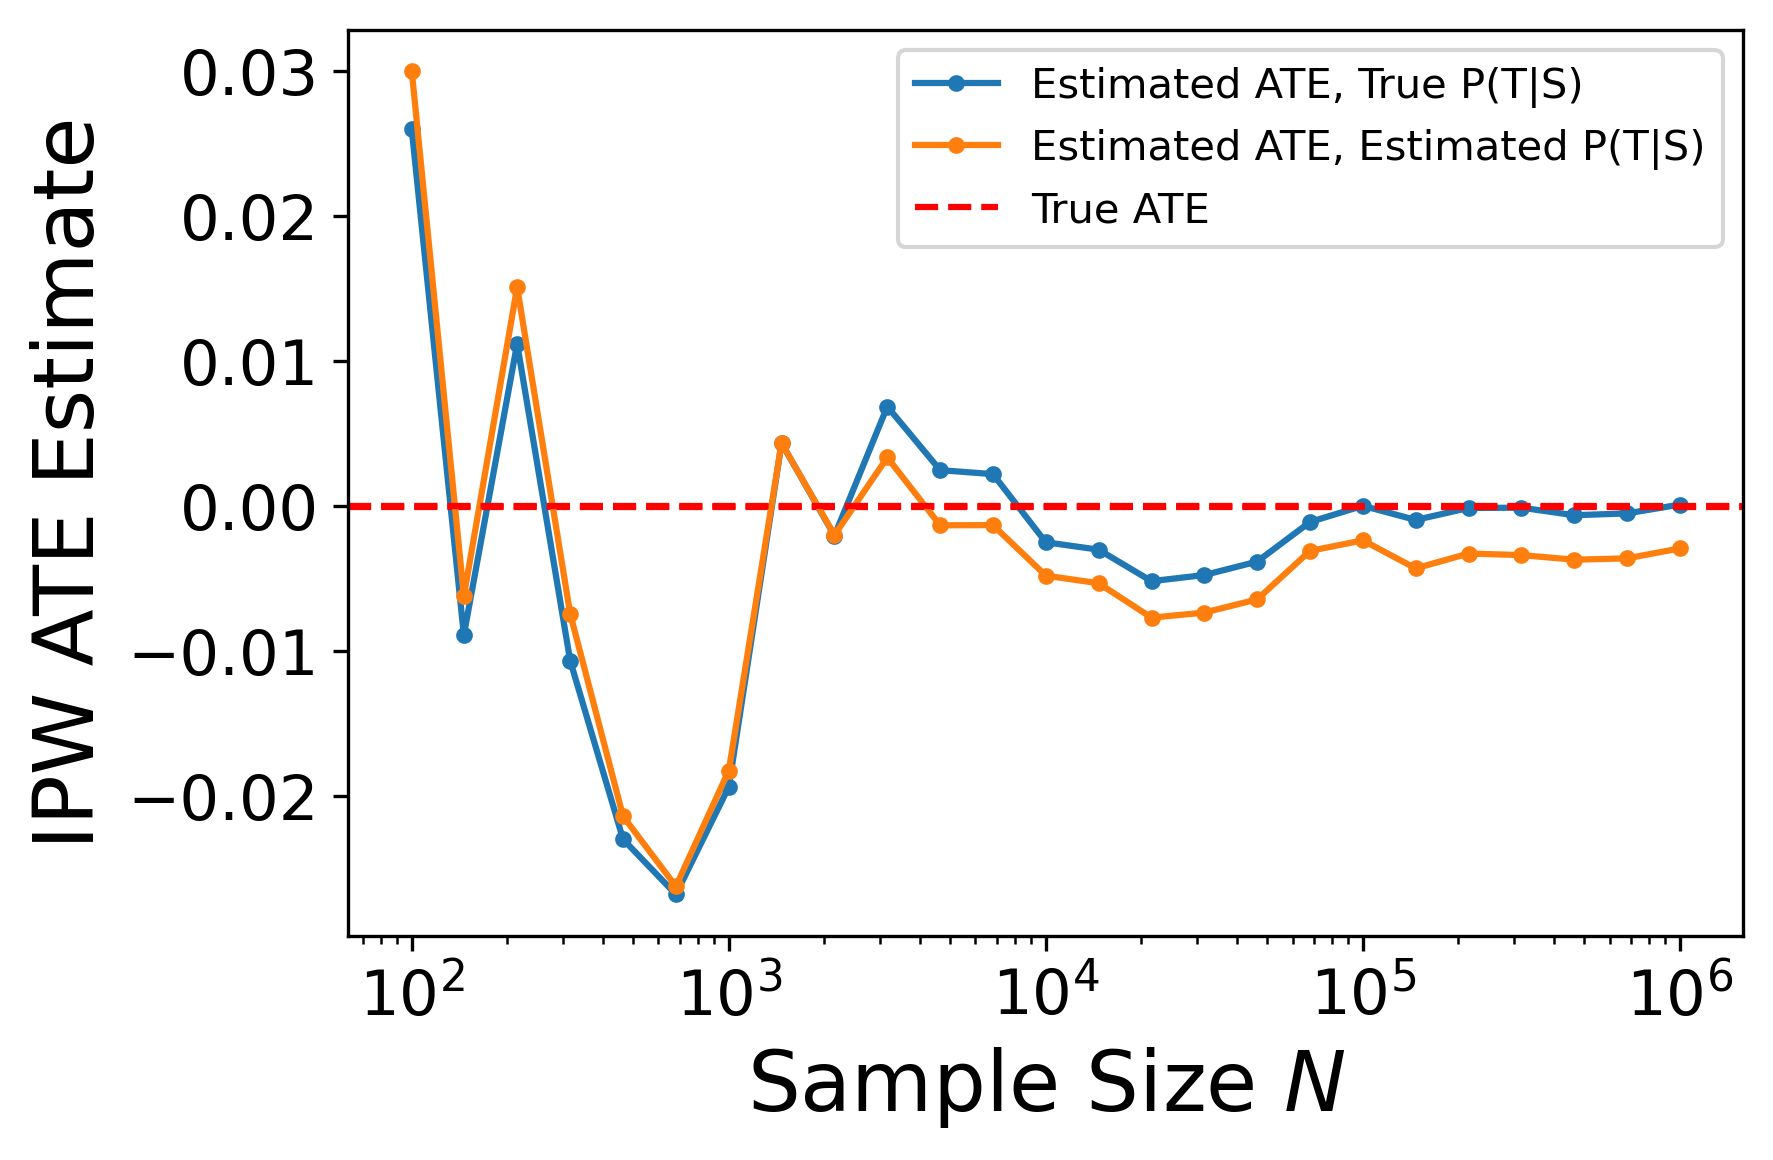

In [83]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt

sample_sizes = np.logspace(2, 6, 25).astype(int)
ate_estimates = []
true_ate = np.mean(Y_func(np.ones_like(S), S) - Y_func(np.zeros_like(S), S))

for n in sample_sizes:
    S_sample = S[:n]
    T_sample = T[:n]
    Y_sample = Y[:n]
    P_sample = P_func(S_sample)
    weights_treated = 1 / P_sample[T_sample == 1]
    weights_untreated = 1 / (1 - P_sample[T_sample == 0])
    ate_estimate = (np.average(Y_sample[T_sample == 1], weights=weights_treated) -
                    np.average(Y_sample[T_sample == 0], weights=weights_untreated))
    ate_estimates.append(compute_IPW_ATE(S[:n], T[:n], Y[:n]))

plt.figure(dpi=300)
plt.plot(sample_sizes, ate_estimates, label="Estimated ATE, True P(T|S)", marker='.')
plt.axhline(y=true_ate, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel(r"Sample Size $N$", size=20)
plt.ylabel("IPW ATE Estimate", size=20)
plt.tick_params(axis='both', labelsize=15)
# plt.title("IPW ATE Convergence with Sample Size")
# plt.savefig("ipw-ate.pdf", bbox_inches="tight")
# plt.show()



# ATE Convergence with Sample Size
sample_sizes = np.logspace(2, 6, 25).astype(int)
ate_estimates = []
true_ate = np.mean(Y_func(np.ones_like(S), S) - Y_func(np.zeros_like(S), S))

# Create a pipeline for polynomial logistic regression (degree 3 as an example)
poly_log_reg = make_pipeline(PolynomialFeatures(degree=3), LogisticRegression())

# Fit polynomial logistic regression on the full dataset to predict P(T=1|S)
poly_log_reg.fit(S.reshape(-1, 1), T)  # S as input, T as the binary treatment (0 or 1)

for n in sample_sizes:
    S_sample = S[:n]
    T_sample = T[:n]
    Y_sample = Y[:n]
    
    # Predict the propensity scores using polynomial logistic regression
    P_sample = poly_log_reg.predict_proba(S_sample.reshape(-1, 1))[:, 1]  # Probabilities of T=1
    
    # Inverse Probability Weighting for treated and untreated groups
    weights_treated = 1 / P_sample[T_sample == 1]
    weights_untreated = 1 / (1 - P_sample[T_sample == 0])
    
    # Calculate IPW ATE
    ate_estimate = (np.average(Y_sample[T_sample == 1], weights=weights_treated) -
                    np.average(Y_sample[T_sample == 0], weights=weights_untreated))
    ate_estimates.append(ate_estimate)

# Plotting the results
# plt.figure(dpi=300)
plt.plot(sample_sizes, ate_estimates, label="Estimated ATE, Estimated P(T|S)", marker='.')
plt.axhline(y=true_ate, color='red', linestyle='--', label="True ATE")
plt.xscale('log')
plt.xlabel(r"Sample Size $N$", size=20)
plt.ylabel("IPW ATE Estimate", size=20)
plt.tick_params(axis='both', labelsize=15)
plt.legend()
plt.savefig("ipw-ate.pdf", bbox_inches="tight")
plt.show()


# Propensity Score Matching

100
186
349
652
1218
2275
4251
7943
14839
27724
51794
96764
180776
337731
630957


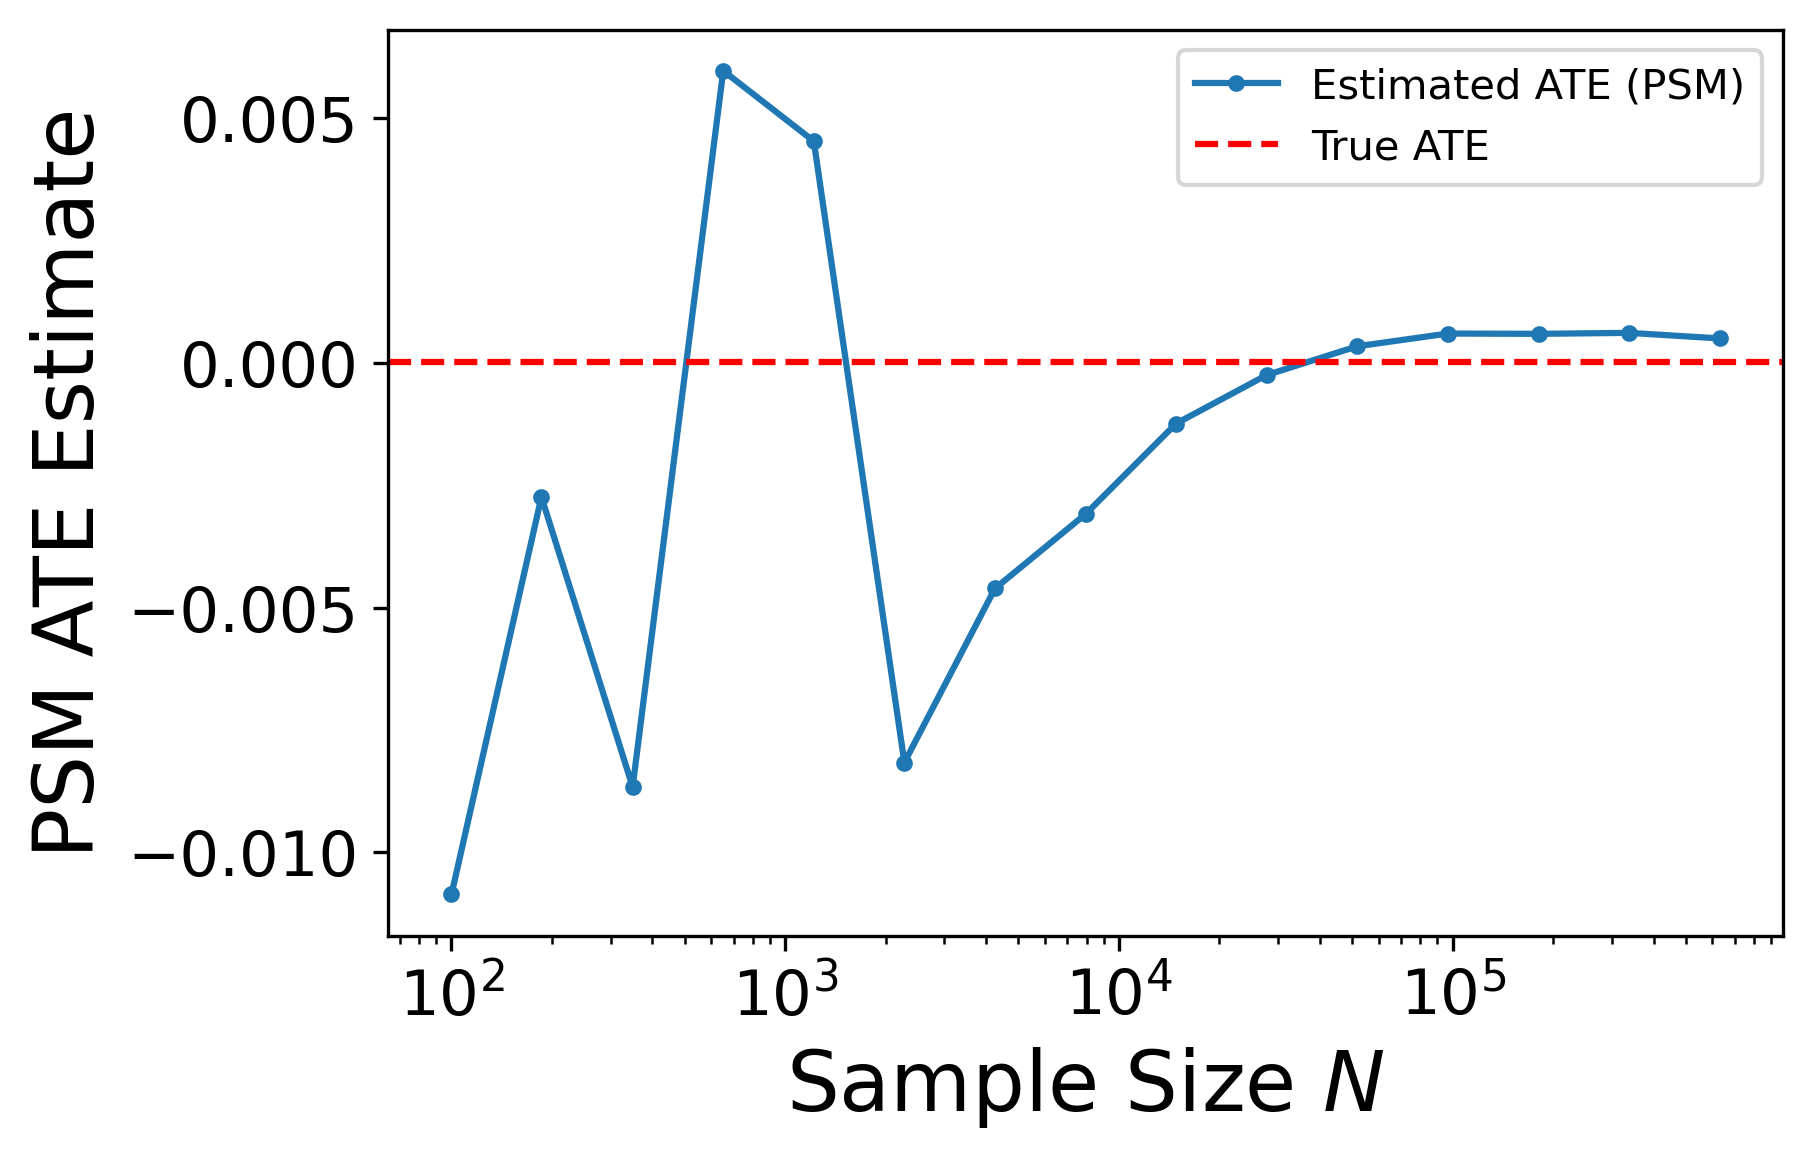

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances_argmin_min

# Define functions
def P_func(S):
    return 2 / np.pi * np.arctan(5 * S)

def Y_func(T, S, std=0.01):
    Y = np.zeros_like(T, dtype=float)
    Y[T == 1] = -0.5 * S[T == 1] + 0.75
    Y[T == 0] = -0.8 * S[T == 0] + 0.9
    return Y + np.random.normal(loc=0.0, scale=std, size=len(T))

def propensity_score_matching(S, T, Y):
    log_reg = LogisticRegression()
    log_reg.fit(S.reshape(-1, 1), T)
    propensity_scores = P_func(S)#log_reg.predict_proba(S.reshape(-1, 1))[:, 1]
    
    treated_indices = np.where((T == 1) & (S<0.7) & (S>0.3))[0]
    untreated_indices = np.where((T == 0) & (S<0.7) & (S>0.3))[0]
    
    matches, _ = pairwise_distances_argmin_min(propensity_scores[treated_indices].reshape(-1, 1),
                                                propensity_scores[untreated_indices].reshape(-1, 1))
    
    Y_treated = Y[treated_indices]
    Y_control = Y[untreated_indices][matches]
    ate_estimate = np.mean(Y_treated) - np.mean(Y_control)
    
    return ate_estimate

sample_sizes = np.logspace(2, 5.8, 15).astype(int)
ate_estimates_psm = []
# true_ate = np.mean(Y_func(np.ones_like(np.random.uniform(size=10000)), np.random.uniform(size=10000)) - 
#                           Y_func(np.zeros_like(np.random.uniform(size=10000)), np.random.uniform(size=10000)))

for n in sample_sizes:
    print(n)
#     S = np.random.uniform(size=n)
#     T = (P_func(S) > np.random.uniform(size=n)).astype(int)
#     Y = Y_func(T, S)

    ate_estimate_psm = propensity_score_matching(S[:n], T[:n], Y[:n])
    ate_estimates_psm.append(ate_estimate_psm)

plt.figure(dpi=300)
plt.plot(sample_sizes, ate_estimates_psm, label="Estimated ATE (PSM)", marker='.')
plt.axhline(y=true_ate, color='red', linestyle='--', label="True ATE")
plt.xscale('log')
plt.xlabel(r"Sample Size $N$", size=20)
plt.ylabel("PSM ATE Estimate", size=20)
plt.tick_params(axis='both', labelsize=15)
# plt.title("Convergence of ATE Estimates with Sample Size (PSM)", fontsize=16)
plt.legend()
plt.savefig("ate_convergence_psm.pdf", bbox_inches="tight")
plt.show()